In [83]:
# read neccessary libraries
import numpy as np
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

pd.options.display.max_rows = 20

np.set_printoptions(precision = 4, suppress = True)

In [26]:
def get_team_name(soup):
    title = soup.find('title')
    pattern = '<title>(.*) Statistics | Premier League</title>'
    regex = re.compile(pattern, flags=re.IGNORECASE)
    team_name = regex.match(str(title)).groups()[0]
    return team_name

# Return the filtered club name for the given index 
def get_premier_teams(target_teams, i):
    pattern = '<h4 class="clubName">(.*)<'
    regex = re.compile(pattern, flags=re.IGNORECASE)
    result = regex.match(str(target_teams[i])).groups()
    return result[0]

In [27]:
# Get the 20 Premier League teams (first division)

premier_teams = []
url = "https://www.premierleague.com/clubs?se=210"
res = requests.get(url)
soup = BeautifulSoup(res.content)
target_teams = soup.find_all('h4', attrs={'clubName'})

for i in range(0,20):
    premier_teams.append(get_premier_teams(target_teams, i))

premier_teams

['Arsenal',
 'Aston Villa',
 'AFC Bournemouth',
 'Brighton and Hove Albion',
 'Burnley',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Leicester City',
 'Liverpool',
 'Manchester City',
 'Manchester United',
 'Newcastle United',
 'Norwich City',
 'Sheffield United',
 'Southampton',
 'Tottenham Hotspur',
 'Watford',
 'West Ham United',
 'Wolverhampton Wanderers']

In [28]:
headers = ['Team', 'Matches Played', 'Wins']
team_stats = []
premier_teams_index = []

# Iterate through clubs using numbers 1-46 in the URL
# Since the 20 Premier League teams are found in mixed order with second division teams, we have to extract all
for team in range(1,46):
    url = "https://www.premierleague.com/clubs/" + str(team) + "/club/stats"  
    res = requests.get(url)                                                     
    soup = BeautifulSoup(res.content)
    
    team_name = get_team_name(soup)
    
    # Filter out FC from the football clubs' names
    if 'FC' in team_name:
        team_name = team_name[:-3]
        
    # Filter out teams that aren't in the Premier League
    if team_name not in premier_teams:
        continue
    
    # Append the indices (for URL) of the Premier League teams (first division)
    premier_teams_index.append(team)    
      
    # Find all the stats that are enclosed in 'div' classed as normalStat
    all_stats = soup.find_all('div', attrs={'normalStat'})                     

    stats = [team_name]
    
    # Find number of matches played
    matches = soup.find_all('div', attrs={'topStat'})[0].findChildren()[0]
    pattern = '(.*)\\n( *)(.*)'
    regex = re.compile(pattern, flags=re.IGNORECASE)
    result = regex.match(str(matches)).groups()
    value = result[-1].replace(',', '')
    stats.append(int(value))
    
    # Find number of wins
    win_stats = soup.find_all('div', attrs={'topStat'})[1].findChildren()[0]
    pattern = '(.*)\\n( *)(.*)'
    regex = re.compile(pattern, flags=re.IGNORECASE)
    result = regex.match(str(win_stats)).groups()
    stats.append(int(result[-1]))

    
    for i in range(0,30): 
        
        # Filter the first child from each 'div' tag which contains the stat name
        span = all_stats[i].findChildren()[0]
        
        # Only need to extract headers once
        if team == 1:                     
            pattern = '<span class="stat">(.*)<(.*)'
            regex = re.compile(pattern, flags=re.IGNORECASE)
            result = regex.match(str(span)).groups()
            headers.append(result[0].strip())
        
        # Extract the statistical data
        pattern = '(.*)\\n( *)(.*)'
        regex = re.compile(pattern, flags=re.IGNORECASE)
        result = regex.match(str(span)).groups()
                
        value = result[2].replace(',','').replace('%','')
    
        # Use float for appropriate values
        if (value.isdigit()):
            data_value = int(value) 
        else:
            data_value = float(value)
        stats.append(data_value)
        
    team_stats.append(stats)

In [29]:
# All stats

stats = pd.DataFrame(team_stats, columns=headers).set_index('Team')
stats

,Matches Played,Wins,Goals,Goals per match,Shots,Shots on target,Shooting accuracy %,Penalties scored,Big chances created,Hit woodwork,...,Interceptions,Clearances,Headed Clearance,Aerial Battles/Duels Won,Errors leading to goal,Own goals,Yellow cards,Red cards,Fouls,Offsides
Team,,,,,,,,,,,,,,,,,,,,,
Arsenal,1062,571,1877,1.77,8072,2916,36,58,716,221,...,8009,14057,5196,36667,113,41,1603,91,1360,1206
Aston Villa,949,323,1148,1.21,4861,1572,32,37,272,109,...,6235,14411,4568,28836,76,46,1405,57,738,942
Chelsea,1062,570,1811,1.71,8889,3006,34,69,591,199,...,6636,13181,4985,35792,66,36,1670,78,1282,1299
Crystal Palace,412,118,447,1.08,2956,946,32,39,259,69,...,3826,7161,3833,20544,52,16,644,21,1441,454
Everton,1062,385,1385,1.30,6976,2366,34,49,511,164,...,7070,17276,6078,36259,85,52,1613,95,1468,1131
Liverpool,1062,551,1828,1.72,8803,2974,34,68,637,253,...,6681,14187,5000,36018,89,39,1325,59,1303,1202
Manchester City,872,407,1439,1.65,8336,2930,35,71,772,216,...,7141,14135,4892,33996,62,38,1305,68,1421,1209
Manchester United,1063,657,2025,1.90,8083,2893,36,66,618,203,...,7188,15486,5874,34473,59,39,1517,66,1508,1223
Norwich City,340,93,389,1.14,2094,670,32,7,178,50,...,2265,5463,2066,11176,43,18,441,16,492,341


In [30]:
# Filter only the relevant stats

key_stats = stats.filter(['Matches Played', 'Wins', 'Penalties scored', 'Shots on target',
                               'Big chances created', 'Hit woodwork', 'Passes', 'Crosses',
                               'Saves', 'Tackles', 'Blocked shots', 'Interceptions',
                               'Clearances', 'Aerial Battles/Duels Won', 'Own goals',
                         'Yellow cards', 'Red cards', 'Fouls'])
key_stats

,Matches Played,Wins,Penalties scored,Shots on target,Big chances created,Hit woodwork,Passes,Crosses,Saves,Tackles,Blocked shots,Interceptions,Clearances,Aerial Battles/Duels Won,Own goals,Yellow cards,Red cards,Fouls
Team,,,,,,,,,,,,,,,,,,
Arsenal,1062,571,58,2916,716,221,278479,11342,793,10307,2097,8009,14057,36667,41,1603,91,1360
Aston Villa,949,323,37,1572,272,109,146976,9269,425,8515,1190,6235,14411,28836,46,1405,57,738
Chelsea,1062,570,69,3006,591,199,268239,11590,602,10229,2392,6636,13181,35792,36,1670,78,1282
Crystal Palace,412,118,39,946,259,69,89933,5007,758,4818,788,3826,7161,20544,16,644,21,1441
Everton,1062,385,49,2366,511,164,213629,11758,708,9959,1871,7070,17276,36259,52,1613,95,1468
Liverpool,1062,551,68,2974,637,253,268512,11684,549,11205,2243,6681,14187,36018,39,1325,59,1303
Manchester City,872,407,71,2930,772,216,275683,10907,510,10142,2193,7141,14135,33996,38,1305,68,1421
Manchester United,1063,657,66,2893,618,203,265683,12396,692,10043,2105,7188,15486,34473,39,1517,66,1508
Norwich City,340,93,7,670,178,50,68965,3633,316,3059,520,2265,5463,11176,18,441,16,492


In [31]:
# Stats per match

stats_per_match = key_stats.copy()

for column in stats_per_match:
    if column == 'Matches Played':
        continue
    stats_per_match[column] = stats_per_match[column] / stats_per_match['Matches Played']
    
stats_per_match

,Matches Played,Wins,Penalties scored,Shots on target,Big chances created,Hit woodwork,Passes,Crosses,Saves,Tackles,Blocked shots,Interceptions,Clearances,Aerial Battles/Duels Won,Own goals,Yellow cards,Red cards,Fouls
Team,,,,,,,,,,,,,,,,,,
Arsenal,1062,0.537665,0.054614,2.745763,0.674200,0.208098,262.221281,10.679849,0.746704,9.705273,1.974576,7.541431,13.236347,34.526365,0.038606,1.509416,0.085687,1.280603
Aston Villa,949,0.340358,0.038988,1.656481,0.286617,0.114858,154.874605,9.767123,0.447840,8.972603,1.253952,6.570074,15.185458,30.385669,0.048472,1.480506,0.060063,0.777661
Chelsea,1062,0.536723,0.064972,2.830508,0.556497,0.187382,252.579096,10.913371,0.566855,9.631827,2.252354,6.248588,12.411488,33.702448,0.033898,1.572505,0.073446,1.207156
Crystal Palace,412,0.286408,0.094660,2.296117,0.628641,0.167476,218.283981,12.152913,1.839806,11.694175,1.912621,9.286408,17.381068,49.864078,0.038835,1.563107,0.050971,3.497573
Everton,1062,0.362524,0.046139,2.227872,0.481168,0.154426,201.157250,11.071563,0.666667,9.377589,1.761770,6.657250,16.267420,34.142185,0.048964,1.518832,0.089454,1.382298
Liverpool,1062,0.518832,0.064030,2.800377,0.599812,0.238230,252.836158,11.001883,0.516949,10.550847,2.112053,6.290960,13.358757,33.915254,0.036723,1.247646,0.055556,1.226930
Manchester City,872,0.466743,0.081422,3.360092,0.885321,0.247706,316.150229,12.508028,0.584862,11.630734,2.514908,8.189220,16.209862,38.986239,0.043578,1.496560,0.077982,1.629587
Manchester United,1063,0.618062,0.062088,2.721543,0.581373,0.190969,249.936971,11.661336,0.650988,9.447789,1.980245,6.761994,14.568203,32.429915,0.036689,1.427093,0.062088,1.418627
Norwich City,340,0.273529,0.020588,1.970588,0.523529,0.147059,202.838235,10.685294,0.929412,8.997059,1.529412,6.661765,16.067647,32.870588,0.052941,1.297059,0.047059,1.447059


In [81]:
def create_corr_plot(data):
    corr = data.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(data.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(data.columns)
    ax.set_yticklabels(data.columns)
    plt.show()
    return corr['Wins']

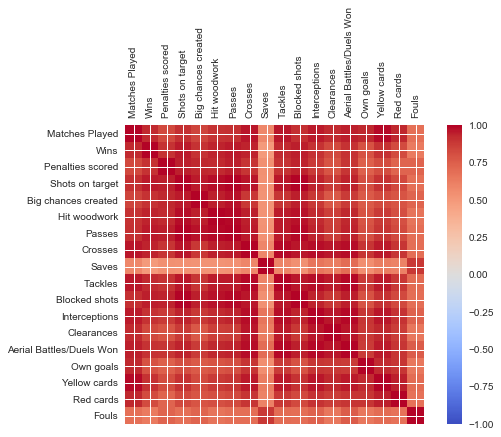

Saves                       0.493026
Fouls                       0.633046
Own goals                   0.803657
Red cards                   0.827293
Clearances                  0.833665
Aerial Battles/Duels Won    0.899303
Yellow cards                0.901370
Penalties scored            0.901673
Interceptions               0.905886
Big chances created         0.905987
Tackles                     0.926916
Matches Played              0.928214
Crosses                     0.938997
Hit woodwork                0.940925
Blocked shots               0.945481
Passes                      0.957956
Shots on target             0.959103
Wins                        1.000000
Name: Wins, dtype: float64


In [88]:
corr_key_stats = create_corr_plot(key_stats)
print(corr_key_stats.sort_values())

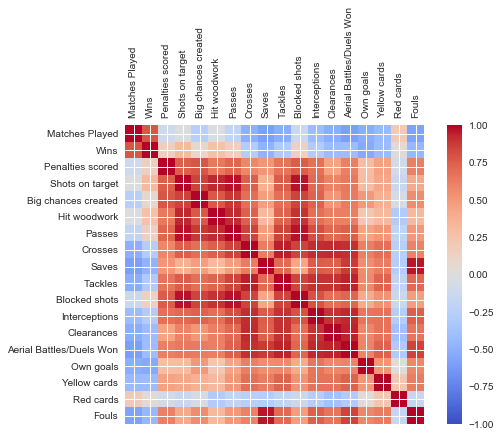

Own goals                  -0.531845
Saves                      -0.472913
Fouls                      -0.439543
Yellow cards               -0.410593
Clearances                 -0.407614
Aerial Battles/Duels Won   -0.403727
Tackles                    -0.296757
Interceptions              -0.281787
Crosses                    -0.274936
Red cards                   0.045548
Big chances created         0.088271
Passes                      0.144001
Blocked shots               0.147382
Penalties scored            0.154316
Hit woodwork                0.272759
Shots on target             0.313544
Matches Played              0.784606
Wins                        1.000000
Name: Wins, dtype: float64


In [87]:
corr_per_match = create_corr_plot(stats_per_match)
print(corr_per_match.sort_values())
